In [32]:
from pathlib import Path
import os
import yaml
import pandas as pd
import numpy as np

from utils.helpers import flatten_dict

import seaborn as sns
import matplotlib.pyplot as plt
import string

from utils.helpers import flatten_dict, set_rcParams
import matplotlib.transforms as transforms



In [33]:
def load_hierarchical_experiment_results(exp_dir, split="test", exclude_strings=["task", "archive", "debug"]):

    # TODO keep path prefixes (e.g. eyepacs/eyepacs_gender/c2st/hash/version_x)

    # TODO save the following variables
    # - date of experiment
    # - subset attribute

    config_dicts = []
    result_dfs = []

    # get all experiments from subfolders
    for path in Path(exp_dir).rglob(f"{split}_consistency_analysis.csv"):
        path_parts = path.parts

        if not set(path_parts).isdisjoint(exclude_strings):
            continue

        version = path_parts[-2]
        exp_hash = path_parts[-3]
        method = path_parts[-4]

        config_file = os.path.join('/' + '/'.join(path_parts[1:-2]), "config.yaml")

        # open config
        with open(config_file) as fhandle:
            params = yaml.safe_load(fhandle)

        params = flatten_dict(params, sep="_")
        result = pd.read_csv(path)
        
        params["exp_hash"] = exp_hash
        result["exp_hash"] = exp_hash
        result["version"] = version
        result["method"] = method
        result["path"] = str(path.parent)
        
        config_dicts.append(params)
        result_dfs.append(result)
        
    configs = pd.DataFrame(config_dicts)
    configs = configs.set_index("exp_hash")
        
    results = pd.concat(result_dfs)
    results = results.set_index(["exp_hash", "sample_size"], drop=False)
    
    # keep latest version only!
    configs = configs[~configs.index.duplicated(keep="last")]
    results = results[~results.index.duplicated(keep="last")]

    
    df = configs.join(results)        
        
    return df




In [34]:
exp_dir = "/home/lkoch/mnt/slurm_work/exp_lightning"

df = load_hierarchical_experiment_results(exp_dir)


KeyboardInterrupt: 

In [17]:

# columns_of_interest = ['dataset_ds_data_augmentation',
#                         'path', 'dataset_ds_basic_preproc_img_size', 'dataset_ds_p_dataset', 'dataset_ds_p_subset_params_center', 
#                         'dataset_ds_q_dataset', 'dataset_ds_q_subset_params_center', 
#                         'domain_classifier_model_arch', 
#                         'domain_classifier_model_optim_config_learning_rate', 'mmd_model_feature_extractor', 'mmd_model_img_size', 'mmd_model_loss_lambda', 
#                         'mmd_model_loss_type', 'task_classifier_model_arch', 'task_classifier_model_optim_config_learning_rate', 
#                         'dataset_ds_p_subset_params_diagnoses_comorbidities', 'dataset_ds_q_subset_params_diagnoses_comorbidities', 'dataset_ds_p_subset_params_patient_ethnicity', 'dataset_ds_q_subset_params_patient_ethnicity', 'dataset_ds_p_subset_params_patient_gender', 'dataset_ds_q_subset_params_patient_gender', 'dataset_ds_p_subset_params_session_image_quality', 'dataset_ds_q_subset_params_session_image_quality', 'dataset_ds_data_frac', 'dataset_ds_p_subset_params_p_erase', 'dataset_ds_p_subset_params_scale_erase', 'dataset_ds_q_subset_params_p_erase', 'dataset_ds_q_subset_params_scale_erase', 'sample_size', 'power', 'type_1err', 'method', 'power_stderr', 'type_1err_stderr', 'exp_hash', 'version'] 
    

# df = df[columns_of_interest]



df.to_csv('all_results.csv')


In [35]:
def add_letters(fig, axs, dx=-35/72., dy=15/72.):
    
    letterkwargs = dict(size=8, weight='bold', va='top', ha='left')

    offset = transforms.ScaledTranslation(
            dx, dy, fig.dpi_scale_trans)

    for idx, ax in enumerate(axs.flat):
        axs.flat[idx].text(0, 1, string.ascii_lowercase[idx], transform=axs.flat[idx].transAxes + offset, 
                    **letterkwargs)

    # for idx in range(len(ax)):
        # ax[idx].text(0, 1, string.ascii_lowercase[idx], transform=ax[idx].transAxes + offset, 
        #             **letterkwargs)


In [36]:
def style_powerplot(ax, y_ticks=[0, 0.25, 0.5, 0.75, 1], xlim=[0, 510], ylim=[0, 1.05], xlabel="Sample size"):

    if xlim is not None:
        ax.set_xlim(xlim)
    if ylim is not None:
        ax.set_ylim(ylim)
    if y_ticks is not None:
        ax.set_yticks(y_ticks)
    ax.grid(False)
    # ax[idx].set(xscale="log")
    ax.set_ylabel("Power", )
    
    if xlabel is not None:
        ax.set_xlabel(xlabel, )
    

In [37]:
powerplot_height = 1.5
y_tick_type1err = [0, 0.02, 0.04, 0.06, 0.08]

# MNIST results

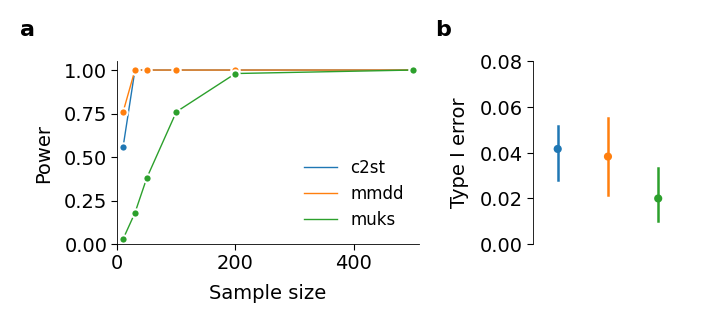

In [16]:
df = pd.read_csv('all_results.csv')

mnist = df[df["dataset_ds_p_dataset"] == "mnist"]
mnist = mnist[mnist["domain_classifier_model_arch"]!= "resnet50"]
mnist.shape


with plt.style.context("../utils/plot_style.txt"):

    num_plots = 2
    fig, ax = plt.subplots(1,
                           num_plots, 
                           figsize=(3.4,powerplot_height), 
                           gridspec_kw={'width_ratios': [2, 1]},
                        )


    idx=0
    sns.lineplot(data=mnist, x='sample_size', y='power', hue='method', ax=ax[0], 
                 marker='.'
                 )
    
    style_powerplot(ax[idx])

    handles, labels = ax[idx].get_legend_handles_labels()
    ax[idx].legend(handles=handles, labels=labels)
    ax[idx].get_legend().get_frame().set_linewidth(0.0)

    idx=1

    bp = sns.pointplot(data=mnist, x="method", y="type_1err", join=False,  ax=ax[idx], palette=sns.color_palette())

    bp.set(xticklabels=[])
    bp.set(xlabel=None)
    bp.set_yticks(y_tick_type1err, )


    ax[idx].set_ylim([0, 0.08])
    ax[idx].set_ylabel("Type I error")

    ax[idx].spines['bottom'].set_visible(False)
    ax[idx].set_xticks([])

    add_letters(fig, ax)

    fig.savefig('mnist_results.pdf')

In [12]:
len(ax)

2

# Camelyon results

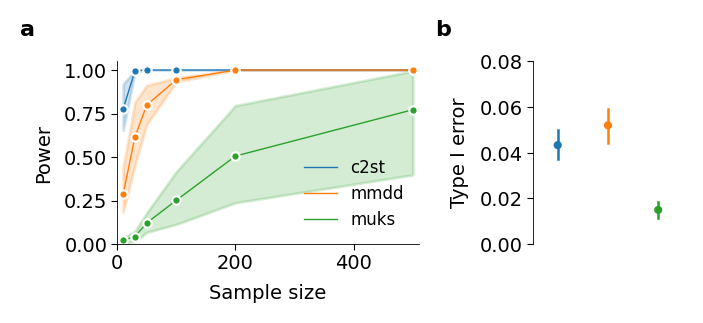

In [29]:
df = pd.read_csv('all_results.csv')

sub_df = df[df["dataset_ds_p_dataset"] == "camelyon"]

with plt.style.context("../utils/plot_style.txt"):

    num_plots = 2
    fig, ax = plt.subplots(1,num_plots, 
                           figsize=(3.4,powerplot_height), 
                           gridspec_kw={'width_ratios': [2, 1]},
                            layout="constrained",
                        )


    idx=0
    sns.lineplot(data=sub_df, x='sample_size', y='power', hue='method', marker='.', ax=ax[0])
    
    
    style_powerplot(ax[idx])
    

    handles, labels = ax[idx].get_legend_handles_labels()
    ax[idx].legend(handles=handles, labels=labels)
    ax[idx].get_legend().get_frame().set_linewidth(0.0)
    ax[idx].get_legend().get_frame().set_alpha(0.0)

    idx=1


    bp = sns.pointplot(data=sub_df, x="method", y="type_1err", join=False,  ax=ax[idx], palette=sns.color_palette())

    bp.set(xticklabels=[])
    bp.set(xlabel=None)

    ax[idx].set_ylim([0, 0.08])
    ax[idx].set_ylabel("Type I error")
    ax[idx].set_yticks(y_tick_type1err, )

    ax[idx].spines['bottom'].set_visible(False)
    ax[idx].set_xticks([])

    add_letters(fig, ax)
    
    fig.savefig('camelyon_results.pdf')


# Eyepacs main results


(18, 104)
(126, 104)


NameError: name 'mnist' is not defined

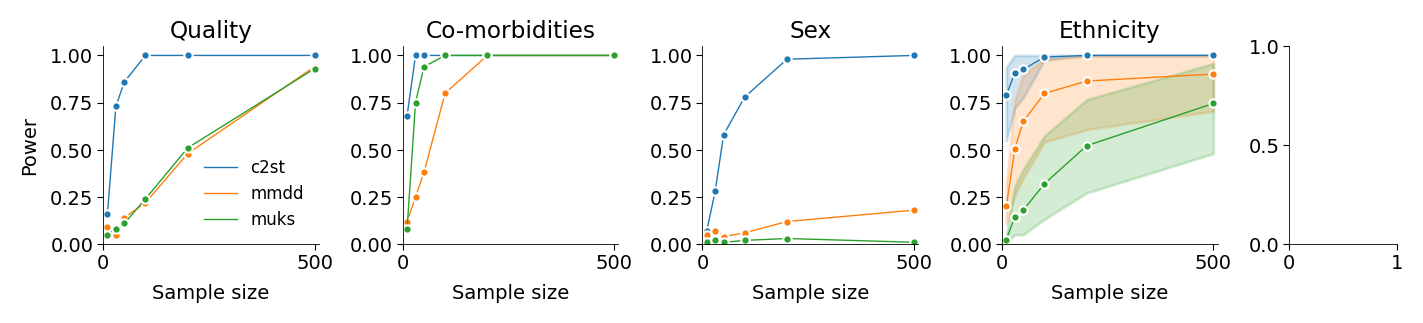

In [351]:
df = pd.read_csv('all_results.csv')

eyepacs = df[df["dataset_ds_p_dataset"] == "eyepacs"]


# eyepacs = eyepacs[eyepacs["dataset_ds_data_frac"]==1]

eyepacs = eyepacs[eyepacs['path'].str.contains("task") == False]
eyepacs = eyepacs[eyepacs['path'].str.contains("eyepacs_quality_data_frac") == False]
eyepacs = eyepacs[eyepacs['path'].str.contains("eyepacs_quality_mmd_ablation") == False]
eyepacs = eyepacs[eyepacs['path'].str.contains("eyepacs_quality_arch") == False]
eyepacs = eyepacs[eyepacs['path'].str.contains("eyepacs_quality_gradual") == False]


drop_rows = (eyepacs['method'] == "c2st") & (eyepacs["dataset_ds_basic_preproc_img_size"] == 96)

eyepacs = eyepacs[drop_rows == False]

# print(drop_rows)
# c2st = c2st[c2st["dataset_ds_basic_preproc_img_size"] == 512]

x = eyepacs
# x = df.dropna(subset=["dataset_ds_q_subset_params_session_image_quality"])
# x["dataset_ds_q_subset_params_session_image_quality"]
x.shape

quality = x.dropna(subset=["dataset_ds_q_subset_params_session_image_quality"])
ethnicity = x.dropna(subset=["dataset_ds_p_subset_params_patient_ethnicity"])
sex = x.dropna(subset=["dataset_ds_p_subset_params_patient_gender"])
comorbids = x.dropna(subset=["dataset_ds_q_subset_params_diagnoses_comorbidities"])

print(quality.shape)
print(ethnicity.shape)


with plt.style.context("../utils/plot_style.txt"):

    num_plots = 5
    fig, ax = plt.subplots(1,num_plots, figsize=(7,powerplot_height), 
                           gridspec_kw={'width_ratios': [2, 2, 2, 2, 1]},
                        layout="constrained",
                        )



    idx=0
    sns.lineplot(data=quality, x='sample_size', y='power', hue='method', ax=ax[idx], marker='.')
    ax[idx].set_title("Quality")
    
    style_powerplot(ax[idx])

    handles, labels = ax[idx].get_legend_handles_labels()
    ax[idx].legend(handles=handles, labels=labels, loc='lower right')
    ax[idx].get_legend().get_frame().set_linewidth(0.0)

    idx=1
    sns.lineplot(data=comorbids, x='sample_size', y='power', hue='method', ax=ax[idx], marker='.')
    ax[idx].set_title("Co-morbidities")
    
    style_powerplot(ax[idx])


    ax[idx].set_ylabel(None)
    ax[idx].get_legend().remove()

    idx=2
    sns.lineplot(data=sex, x='sample_size', y='power', hue='method', ax=ax[idx], marker='.')
    
    ax[idx].set_title("Sex")
    
    style_powerplot(ax[idx])

    ax[idx].set_ylabel(None)
    ax[idx].get_legend().remove()

    idx=3
    sns.lineplot(data=ethnicity, x='sample_size', y='power', hue='method', ax=ax[idx], marker='.')
    ax[idx].set_title("Ethnicity")
    
    style_powerplot(ax[idx])

    ax[idx].set_ylabel(None)
    ax[idx].get_legend().remove()

    idx=4

    bp = sns.pointplot(data=mnist, x="method", y="type_1err", join=False,  ax=ax[idx], palette=sns.color_palette())

    bp.set(xticklabels=[])
    bp.set(xlabel=None)

    ax[idx].set_ylim([0, 0.08])
    ax[idx].set_ylabel("Type I error")
    ax[idx].set_yticks(y_tick_type1err, )

    ax[idx].spines['bottom'].set_visible(False)
    ax[idx].set_xticks([])


    add_letters(fig, ax)

    fig.savefig('eyepacs_main_results.pdf')

    y = comorbids[comorbids['method'] == "muks"]
    print(list(y['path']))

# Influence of Training Set Size

In [33]:
df = pd.read_csv('all_results.csv')

df = df[df["dataset_ds_p_dataset"] == "eyepacs"]
df["dataset_ds_data_frac"] =  df["dataset_ds_data_frac"].fillna(1)



df = df[df['path'].str.contains("task") == False]
# df = df[df['path'].str.contains("eyepacs_quality_data_frac") == False]
df = df[df['path'].str.contains("eyepacs_quality_mmd_ablation") == False]

eyepacs = eyepacs[eyepacs['path'].str.contains("eyepacs_quality_arch") == False]
eyepacs = eyepacs[eyepacs['path'].str.contains("eyepacs_quality_gradual") == False]



x = df.dropna(subset=["dataset_ds_q_subset_params_session_image_quality"])
x["dataset_ds_q_subset_params_session_image_quality"]
x.shape

# c2st = x[x["method"] == "c2st" & x["dataset_ds_basic_preproc_img_size"] == 512]
c2st = x[x["method"] == "c2st"]
c2st = c2st[c2st["dataset_ds_basic_preproc_img_size"] == 512]
mmdd = x[x["method"] == "mmdd"] 
muks = x[x["method"] == "muks"] 

# exclude: mmd ablation experiments
mmdd = mmdd[mmdd['path'].str.contains("mmd_ablation") == False]



findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


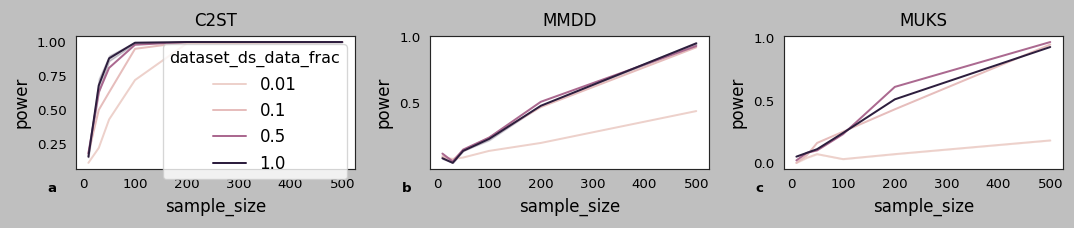

In [34]:

set_rcParams()

fig, ax = plt.subplots(1,3, figsize=(9,2))

idx=0
sns.lineplot(data=c2st, x='sample_size', y='power', hue='dataset_ds_data_frac', ax=ax[0])
ax[idx].set_title("C2ST")

txtkwargs = dict(size=8, weight='bold', va='top', ha='left')
# ax[idx].set(xscale="log")

idx=1
sns.lineplot(ax=ax[idx], data=mmdd, x='sample_size', y='power', hue='dataset_ds_data_frac')
ax[idx].set_title("MMDD")
ax[idx].get_legend().remove()
# ax[idx].set(xscale="log")

idx=2
sns.lineplot(ax=ax[idx], data=muks, x='sample_size', y='power', hue='dataset_ds_data_frac')
ax[idx].set_title("MUKS")
ax[idx].get_legend().remove()
# ax[idx].set(xscale="log")


for idx in range(3):
    ax[idx].text(-0.1, -0.1, string.ascii_lowercase[idx], transform=ax[idx].transAxes, **txtkwargs)

plt.tight_layout()




### Latex table

In [62]:


table_results = pd.concat([c2st, mmdd, muks])
table_results = table_results[['method', 'sample_size', 'power', 'dataset_ds_data_frac']]

table_results = table_results[table_results['sample_size']==100]

table_results['data_frac'] = (table_results['dataset_ds_data_frac'] * 100).astype(int)

table_results = table_results.set_index(['method', 'data_frac'])
table_results
# table_results = table_results.groupby(["sample_size", "method", "dataset_ds_basic_preproc_img_size", "attribute"])['power'].mean().reset_index()

c2st_row = f"C2ST "

fracs = [100, 50, 10, 1]

table_rows = []

title_row_1 = "  & $100\%$ & $50\%$ & $10\%$ & $1\%$ \\\\   \n"
table_rows.append(title_row_1)

table_rows.append("\hline \n")

row = f"C2ST & " + ' & '.join([f"{table_results.loc['c2st', ele]['power'][0]:.02f}" for ele in fracs]) + "\\\\  \n"
table_rows.append(row)

row = f"MMDD & " + ' & '.join([f"{table_results.loc['mmdd', ele]['power'][0]:.02f}" for ele in fracs]) + "\\\\  \n"
table_rows.append(row)

row = f"MUKS & " + ' & '.join([f"{table_results.loc['muks', ele]['power'][0]:.02f}" for ele in fracs]) + "\\\\  \n"
table_rows.append(row)

table_rows.append("\hline \n")


table_file = "train_size_ablation_table.txt"
with open(table_file, "w") as f:
    f.writelines(table_rows)


/tmp/ipykernel_274067/2586167536.py:23: PerformanceWarning: indexing past lexsort depth may impact performance.
  row = f"C2ST & " + ' & '.join([f"{table_results.loc['c2st', ele]['power'][0]:.02f}" for ele in fracs]) + "\\\\  \n"
/tmp/ipykernel_274067/2586167536.py:26: PerformanceWarning: indexing past lexsort depth may impact performance.
  row = f"MMDD & " + ' & '.join([f"{table_results.loc['mmdd', ele]['power'][0]:.02f}" for ele in fracs]) + "\\\\  \n"
/tmp/ipykernel_274067/2586167536.py:29: PerformanceWarning: indexing past lexsort depth may impact performance.
  row = f"MUKS & " + ' & '.join([f"{table_results.loc['muks', ele]['power'][0]:.02f}" for ele in fracs]) + "\\\\  \n"


In [60]:
[f"{table_results.loc['c2st', ele]['power'].values[0]}" for ele in fracs]

# table_results.loc['c2st', 1]['power']

/tmp/ipykernel_274067/2450785649.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  [f"{table_results.loc['c2st', ele]['power'].values[0]}" for ele in fracs]


['1.0', '0.98', '0.95', '0.72']

# Influence of Image Size on C2ST

In [377]:
df = pd.read_csv('all_results.csv')

df = df[df["dataset_ds_p_dataset"] == "eyepacs"]


df = df[df['path'].str.contains("task") == False]
df = df[df['path'].str.contains("eyepacs_quality_data_frac") == False]
df = df[df['path'].str.contains("eyepacs_quality_mmd_ablation") == False]

eyepacs = eyepacs[eyepacs['path'].str.contains("eyepacs_quality_arch") == False]
eyepacs = eyepacs[eyepacs['path'].str.contains("eyepacs_quality_gradual") == False]


df = df[df['method'] != "muks"]

# x = df[df["dataset_ds_data_frac"]==1]

# x = df.dropna(subset=["dataset_ds_q_subset_params_session_image_quality"])
# x["dataset_ds_q_subset_params_session_image_quality"]
x = df

quality = x.dropna(subset=["dataset_ds_q_subset_params_session_image_quality"])
ethnicity = x.dropna(subset=["dataset_ds_p_subset_params_patient_ethnicity"])
sex = x.dropna(subset=["dataset_ds_p_subset_params_patient_gender"])
comorbids = x.dropna(subset=["dataset_ds_q_subset_params_diagnoses_comorbidities"])

# c2st = x[x["method"] == "c2st" & x["dataset_ds_basic_preproc_img_size"] == 512]
c2st = x[x["method"] == "c2st"]
c2st = c2st[c2st["dataset_ds_basic_preproc_img_size"] == 512]
mmdd = x[x["method"] == "mmdd"] 
muks = x[x["method"] == "muks"] 


In [378]:
print(quality.shape)
print(ethnicity.shape)
print(sex.shape)
print(comorbids.shape)


(18, 38)
(126, 38)
(18, 38)
(18, 38)


/tmp/ipykernel_1233934/993644952.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  quality['attribute'] = "Quality"
/tmp/ipykernel_1233934/993644952.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  comorbids['attribute'] = "Co-morbidities"
/tmp/ipykernel_1233934/993644952.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/

method attribute  sample_size  power  dataset_ds_basic_preproc_img_size
306   c2st   Quality           10   0.19                                 96
307   c2st   Quality           30   0.54                                 96
308   c2st   Quality           50   0.78                                 96
309   c2st   Quality          100   0.99                                 96
310   c2st   Quality          200   1.00                                 96
..     ...       ...          ...    ...                                ...
295   mmdd       Sex           30   0.07                                 96
296   mmdd       Sex           50   0.04                                 96
297   mmdd       Sex          100   0.06                                 96
298   mmdd       Sex          200   0.12                                 96
299   mmdd       Sex          500   0.18                                 96

[180 rows x 5 columns]

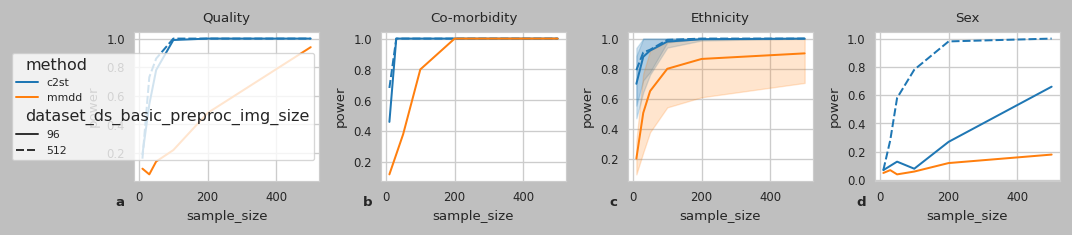

In [382]:

set_rcParams()

fig, ax = plt.subplots(1,4, figsize=(9,2))

idx=0
sns.lineplot(data=quality, x='sample_size', y='power', hue='method', ax=ax[0], style="dataset_ds_basic_preproc_img_size")
ax[idx].set_title("Quality")

txtkwargs = dict(size=8, weight='bold', va='top', ha='left')
# ax[idx].set(xscale="log")

idx=1
sns.lineplot(ax=ax[idx], data=comorbids, x='sample_size', y='power', hue='method', style="dataset_ds_basic_preproc_img_size")
ax[idx].set_title("Co-morbidity")
ax[idx].get_legend().remove()
# ax[idx].set(xscale="log")

idx=2
sns.lineplot(ax=ax[idx], data=ethnicity, x='sample_size', y='power', hue='method', style="dataset_ds_basic_preproc_img_size")
ax[idx].set_title("Ethnicity")
ax[idx].get_legend().remove()
# ax[idx].set(xscale="log")

idx=3
sns.lineplot(ax=ax[idx], data=sex, x='sample_size', y='power', hue='method', style="dataset_ds_basic_preproc_img_size")
ax[idx].set_title("Sex")
ax[idx].get_legend().remove()
# ax[idx].set(xscale="log")


for idx in range(4):
    ax[idx].text(-0.1, -0.1, string.ascii_lowercase[idx], transform=ax[idx].transAxes, **txtkwargs)

plt.tight_layout()

quality['attribute'] = "Quality"
comorbids['attribute'] = "Co-morbidities"
ethnicity['attribute'] = "Ethnicity"
sex['attribute'] = "Sex"



In [412]:


table_results = pd.concat([quality, comorbids, ethnicity, sex])
table_results = table_results[['method', 'attribute', 'sample_size', 'power', 'dataset_ds_basic_preproc_img_size']]

table_results
table_results = table_results.groupby(["sample_size", "method", "dataset_ds_basic_preproc_img_size", "attribute"])['power'].mean().reset_index()


table_rows = []

title_row_1 = "Shift & Test & 10 & 30 & 50 & 100 & 200 & 500 \n"
table_rows.append(title_row_1)

table_rows.append("\hline \n")

for shift_type in table_results['attribute'].unique():
    print(shift_type)

    c2st512 = table_results[(table_results['attribute'] == shift_type) & (table_results['dataset_ds_basic_preproc_img_size'] == 512)]
    c2st96 = table_results[(table_results['attribute'] == shift_type) & (table_results['dataset_ds_basic_preproc_img_size'] == 96)  & (table_results['method'] == "c2st")]
    mmdd = table_results[(table_results['attribute'] == shift_type) & (table_results['method'] == "mmdd")]

    row = f"{shift_type} & C2ST-512 & " + ' & '.join([f"{ele:.02f}" for ele in list(c2st512['power'])]) + "\\\\  \n"
    table_rows.append(row)

    row = f"{shift_type} & C2ST-96 & " + ' & '.join([f"{ele:.02f}" for ele in list(c2st96['power'])]) + "\\\\  \n"
    table_rows.append(row)

    row = f"{shift_type} & MMDD-96 & " + ' & '.join([f"{ele:.02f}" for ele in list(mmdd['power'])]) + "\\\\  \n"
    table_rows.append(row)

    table_rows.append("\hline \n")


table_file = "size_ablation_table.txt"
with open(table_file, "w") as f:
    f.writelines(table_rows)


Co-morbidities
['0.68', '1.00', '1.00', '1.00', '1.00', '1.00']
['0.46', '1.00', '1.00', '1.00', '1.00', '1.00']
['0.12', '0.25', '0.38', '0.80', '1.00', '1.00']
Co-morbidities & C2ST-512 & 0.68 & 1.00 & 1.00 & 1.00 & 1.00 & 1.00\\  

Co-morbidities & C2ST-96 & 0.46 & 1.00 & 1.00 & 1.00 & 1.00 & 1.00\\  

Co-morbidities & MMDD-96 & 0.12 & 0.25 & 0.38 & 0.80 & 1.00 & 1.00\\  

Ethnicity
['0.79', '0.91', '0.93', '0.99', '1.00', '1.00']
['0.70', '0.88', '0.92', '0.98', '1.00', '1.00']
['0.20', '0.50', '0.65', '0.80', '0.86', '0.90']
Ethnicity & C2ST-512 & 0.79 & 0.91 & 0.93 & 0.99 & 1.00 & 1.00\\  

Ethnicity & C2ST-96 & 0.70 & 0.88 & 0.92 & 0.98 & 1.00 & 1.00\\  

Ethnicity & MMDD-96 & 0.20 & 0.50 & 0.65 & 0.80 & 0.86 & 0.90\\  

Quality
['0.16', '0.73', '0.86', '1.00', '1.00', '1.00']
['0.19', '0.54', '0.78', '0.99', '1.00', '1.00']
['0.09', '0.05', '0.14', '0.22', '0.48', '0.94']
Quality & C2ST-512 & 0.16 & 0.73 & 0.86 & 1.00 & 1.00 & 1.00\\  

Quality & C2ST-96 & 0.19 & 0.54 & 0.78 & 

# MMD ablation

- Data augmentation yes/no
- Architecture backbon Liu (original) / Resnet50

/home/lkoch/miniconda3/envs/rebuttal/lib/python3.9/site-packages/pandas/core/indexing.py:1681: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = empty_value
/home/lkoch/miniconda3/envs/rebuttal/lib/python3.9/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


Text(0.5, 1.0, 'MMD ablation')

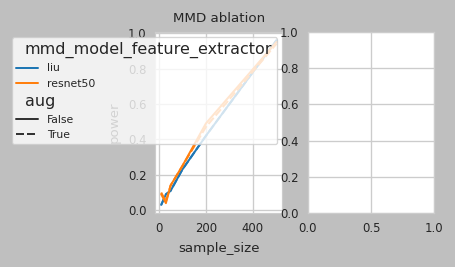

In [222]:
# exclude: mmd ablation experiments
mmdd = mmdd[mmdd['path'].str.contains("mmd_ablation")]

mmdd.shape

df = df[df["dataset_ds_p_dataset"] == "eyepacs"]

x = df[df['path'].str.contains("mmd_ablation")]

x.shape

# x['aug'] = x["dataset_ds_data_augmentation"].apply(len) > 0
x.loc[x.index.tolist(), 'aug'] = x["dataset_ds_data_augmentation"].apply(len) > 0
# x['aug'] = x['aug'] * 1

# # 'dataset_ds_data_augmentation', 'mmd_model_feature_extractor',

set_rcParams()

fig, ax = plt.subplots(1,2, figsize=(3,2))

idx=0
sns.lineplot(data=x, x='sample_size', y='power', hue='mmd_model_feature_extractor', ax=ax[0], style="aug")
ax[idx].set_title("MMD ablation")

# txtkwargs = dict(size=8, weight='bold', va='top', ha='left')
# ax[idx].set(xscale="log")

 




In [223]:
# y = x["dataset_ds_data_augmentation"].iloc[0]

# x['aug'] = x["dataset_ds_data_augmentation"].apply(len) > 0
# x['aug'] = x["dataset_ds_data_augmentation"].apply(lambda row: row.len > 0, axis=1)
# x["dataset_ds_data_augmentation"].apply(len) > 0


x[['power', 'aug', 'mmd_model_feature_extractor']]
# len(y)


power    aug  \
exp_hash                         sample_size                 
72046db431aa631aa2e65d31b58cd269 10            0.03   True   
                                 30            0.09   True   
                                 50            0.11   True   
                                 100           0.23   True   
                                 200           0.42   True   
                                 500           0.96   True   
790524599b4484f4000d80befe4c5853 10            0.10   True   
                                 30            0.05   True   
                                 50            0.14   True   
                                 100           0.25   True   
                                 200           0.47   True   
                                 500           0.94   True   
803f18a148590c2d925eb90a784ff259 10            0.03  False   
                                 30            0.09  False   
                                 50            0.11  False   
                                 100           0.23  False   
                                 200           0.42  False   
                                 500           0.96  False   
c8ebfac3829cf454cd2c84d50a011199 10            0.09  False   
                                 30            0.04  False   
                                 50            0.14  False   
                                 100           0.25  False   
                                 200           0.49  False   
                                 500           0.95  False   

                                             mmd_model_feature_extractor  
exp_hash                         sample_size                              
72046db431aa631aa2e65d31b58cd269 10                                  liu  
                                 30                                  liu  
                                 50                                  liu  
                                 100                                 liu  
                                 200                                 liu  
                                 500                                 liu  
790524599b4484f4000d80befe4c5853 10                             resnet50  
                                 30                             resnet50  
                                 50                             resnet50  
                                 100                            resnet50  
                                 200                            resnet50  
                                 500                            resnet50  
803f18a148590c2d925eb90a784ff259 10                                  liu  
                                 30                                  liu  
                                 50                                  liu  
                                 100                                 liu  
                                 200                                 liu  
                                 500                                 liu  
c8ebfac3829cf454cd2c84d50a011199 10                             resnet50  
                                 30                             resnet50  
                                 50                             resnet50  
                                 100                            resnet50  
                                 200                            resnet50  
                                 500                            resnet50

# Influence of gradual overrepresentation of low quality

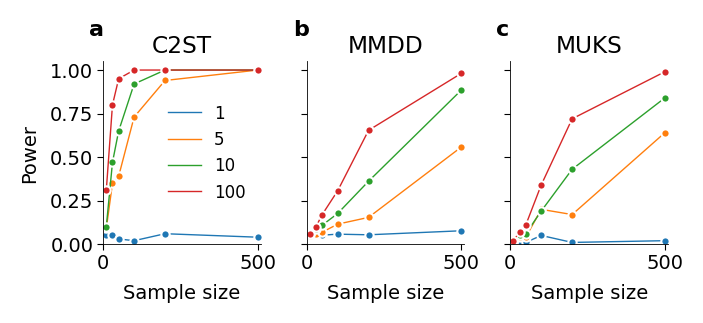

In [27]:
df = pd.read_csv('all_results.csv')

df = df[df["dataset_ds_p_dataset"] == "eyepacs"]


df = df[df['path'].str.contains("eyepacs_quality_gradual")]


# df['shift_strength'] = df['dataset_dl_q_sampling_weights'][1]
# df['shift_strength'] = np.array(df['dataset_dl_q_sampling_weights'].tolist())[:,1]

def str_to_list(in_string):
    l_x = [i.strip() for i in in_string[1:-1].split(',')]
    return l_x

w = df['dataset_dl_q_sampling_weights'].apply(str_to_list)
df['shift_strength'] = np.array(w.tolist())[:,1]


hue_order = ['1', '5', '10', '100']

with plt.style.context("../utils/plot_style.txt"):

    num_plots = 3
    fig, ax = plt.subplots(1,num_plots, figsize=(3.4,powerplot_height), 
                        #    gridspec_kw={'width_ratios': [2, 2, 2, 1]},
                        layout="constrained",
                        sharey=True,
                        )



    idx=0
    sns.lineplot(data=df[df['method']=='c2st'], x='sample_size', y='power', hue='shift_strength', 
                 hue_order=hue_order,
                 ax=ax[idx], 
                 marker='.'
                 )
    ax[idx].set_title('C2ST')
    
    style_powerplot(ax[idx])

    handles, labels = ax[idx].get_legend_handles_labels()
    ax[idx].legend(handles=handles, labels=labels)
    ax[idx].get_legend().get_frame().set_linewidth(0.0)
    
    
    idx=1
    sns.lineplot(data=df[df['method']=='mmdd'], x='sample_size', y='power', hue='shift_strength',
                 hue_order=hue_order,
                 ax=ax[idx], 
                 marker='.'
                 )
    
    ax[idx].set_title('MMDD')
    
    style_powerplot(ax[idx])
    
    ax[idx].get_legend().remove()

    
    idx=2
    sns.lineplot(data=df[df['method']=='muks'], x='sample_size', y='power', hue='shift_strength', 
                                  hue_order=hue_order,
                 ax=ax[idx], 
                 marker='.'
                 )
    
    ax[idx].set_title('MUKS')

    style_powerplot(ax[idx])

    ax[idx].get_legend().remove()

    add_letters(fig, ax, dx=-5/72.)

    fig.savefig('eyepacs_gradual.pdf')


## Same, but with n_train = 1000

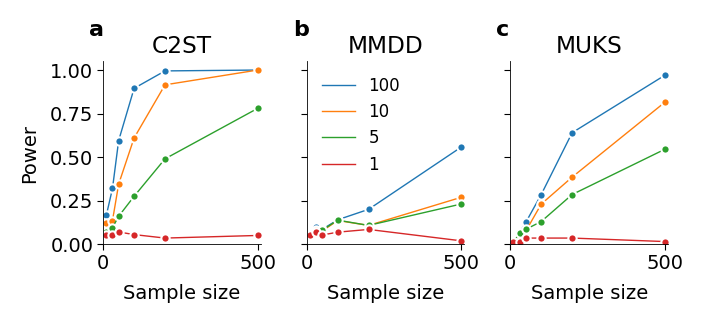

In [50]:
df = pd.read_csv('all_results_dh.csv')


df = df[df['path'].str.contains("/gradual/")]
df = df[df['path'].str.contains("/eyepacs_quality/")]


# df['shift_strength'] = df['dataset_dl_q_sampling_weights'][1]
# df['shift_strength'] = np.array(df['dataset_dl_q_sampling_weights'].tolist())[:,1]

def str_to_list(in_string):
    l_x = [i.strip() for i in in_string[1:-1].split(',')]
    return l_x

w = df['dataset_dl_q_sampling_weights'].apply(str_to_list)
df['shift_strength'] = np.array(w.tolist())[:,1]

hue_order = ['100', '10', '5', '1', ]

with plt.style.context("../utils/plot_style.txt"):

    num_plots = 3
    fig, ax = plt.subplots(1,num_plots, figsize=(3.4,powerplot_height), 
                        #    gridspec_kw={'width_ratios': [2, 2, 2, 1]},
                        layout="constrained",
                        sharey=True,
                        )



    idx=0
    sns.lineplot(data=df[df['method']=='c2st'], x='sample_size', y='power', hue='shift_strength', 
                 hue_order=hue_order,
                    ci=None,
                 ax=ax[idx], 
                 marker='.'
                 )
    ax[idx].set_title('C2ST')
    
    style_powerplot(ax[idx])
    
    ax[idx].get_legend().remove()
    
    idx=1
    sns.lineplot(data=df[df['method']=='mmdd'], x='sample_size', y='power', hue='shift_strength',
                 hue_order=hue_order,
                ci=None,
                 ax=ax[idx], 
                 marker='.'
                 )
    
    ax[idx].set_title('MMDD')
    
    style_powerplot(ax[idx])
    
    handles, labels = ax[idx].get_legend_handles_labels()
    ax[idx].legend(handles=handles, labels=labels)
    ax[idx].get_legend().get_frame().set_linewidth(0.0)
    
    idx=2
    sns.lineplot(data=df[df['method']=='muks'], x='sample_size', y='power', hue='shift_strength', 
                                  hue_order=hue_order,
                ci=None,
                 ax=ax[idx], 
                 marker='.'
                 )
    
    ax[idx].set_title('MUKS')

    style_powerplot(ax[idx])

    ax[idx].get_legend().remove()

    add_letters(fig, ax, dx=-5/72.)

    fig.savefig('eyepacs_gradual.pdf')

# Limited training set size (absolute numbers)

In [38]:
exp_dir = "/home/lkoch/mnt/slurm_work/exp_lightning/eyepacs_seeded_trainset_limited_debug"

df = load_hierarchical_experiment_results(exp_dir, exclude_strings=["task", "archive"])

print(df.shape)


(2106, 93)


In [39]:

df.to_csv('all_results_dh.csv')



In [5]:

df = pd.read_csv('all_results_dh.csv')

df['n_total'] = df['dataset_ds_data_size_abs'] + df['sample_size']


df = df[df['path'].str.contains("c2st96") == False]
df = df[df['path'].str.contains("gradual") == False]
df = df[df['path'].str.contains("c2st_arch") == False]



quality = df[df['path'].str.contains("/eyepacs_quality/")]
ethnicity = df[df['path'].str.contains("/eyepacs_ethnicity/")]
sex = df[df['path'].str.contains("/eyepacs_sex/")]
comorbids = df[df['path'].str.contains("/eyepacs_comorb/")]
quality_OOD = df[df['path'].str.contains("/eyepacs_quality_OOD/")]

# keep Latin American and Caucasian only

# ethnicity = ethnicity.dropna(subset=["dataset_ds_q_subset_params_patient_ethnicity"])

# # function that checks whether the integer 1 is in the list
# def contains_main_groups(lst):
#     # return "Caucasian" in lst
#     # return "African Descent" in lst
#     return "African Descent" in lst or "Caucasian" in lst
#     # return "Latin American" in lst or "Caucasian" in lst
#     # return "Asian" in lst

# ethnicity = ethnicity[ethnicity['dataset_ds_q_subset_params_patient_ethnicity'].apply(contains_main_groups)]


print(df.shape)
print(quality.shape)
print(ethnicity.shape)



(1836, 96)
(216, 96)
(936, 96)


In [6]:
df['path']

120     /home/lkoch/mnt/slurm_work/exp_lightning/eyepa...
121     /home/lkoch/mnt/slurm_work/exp_lightning/eyepa...
122     /home/lkoch/mnt/slurm_work/exp_lightning/eyepa...
123     /home/lkoch/mnt/slurm_work/exp_lightning/eyepa...
124     /home/lkoch/mnt/slurm_work/exp_lightning/eyepa...
                              ...                        
1951    /home/lkoch/mnt/slurm_work/exp_lightning/eyepa...
1952    /home/lkoch/mnt/slurm_work/exp_lightning/eyepa...
1953    /home/lkoch/mnt/slurm_work/exp_lightning/eyepa...
1954    /home/lkoch/mnt/slurm_work/exp_lightning/eyepa...
1955    /home/lkoch/mnt/slurm_work/exp_lightning/eyepa...
Name: path, Length: 1836, dtype: object

In [252]:
ethnicity[(ethnicity['method'] == 'c2st') & (ethnicity['sample_size'] == 100)][['dataset_ds_data_size_abs', 'power', 'dataset_ds_q_subset_params_patient_ethnicity']].sort_values(by='dataset_ds_data_size_abs')

dataset_ds_data_size_abs  power  \
exp_hash                         sample_size                                    
c257baf20fd3d784dd11e44caf301521 100                               100   1.00   
236f1f40303e2ed924340d7b0f9762b8 100                               100   1.00   
ad049883f29a494072f115033d904058 100                               100   0.59   
6adafc243fa5aba3a6129b8692544c41 100                               100   0.11   
ded60609c4497503fa21a18eb2ae66ed 100                               500   1.00   
bc4a7609827ac14e9b4d42ea633f0f4c 100                               500   0.94   
59424da3ea9d2a761d261bc3b466b30c 100                               500   1.00   
7e11b4515b76d6c237d5f358519ada95 100                               500   1.00   
1840b4ebb850d4811efb6235a272fa2f 100                              1000   1.00   
b010b13616833479b4c09d557a0e4128 100                              1000   0.98   
7fcc8c2f6d6a2220dc5e545eec01d049 100                              1000   1.00   
c4fa59b9b4caec24c2aabd8dd84b6897 100                              1000   0.97   
080e5648da40316b60fda13c0918fb05 100                              2000   1.00   
52c74a2bef429ac198c316352d6d4bba 100                              2000   1.00   
2f9c03c661e0f680ca7373bd00d265b5 100                              2000   1.00   
679b2ee4b3bdad46cc8f0663c80be570 100                              2000   1.00   
9c071297a41eb9ef062c3dba5488b55b 100                              5000   1.00   
4f58a2bffca415c793d35434c1811725 100                              5000   1.00   
218ae8cfc775ba53ed92dd1f86305468 100                              5000   1.00   
661e46c939d0b7cac24982be1dfd3592 100                              5000   1.00   
b8a54c6d3eedeaa029493cb7a194ecd5 100                             10000   1.00   
0e34f99241549270f3bde459f55f4478 100                             10000   1.00   

                                             dataset_ds_q_subset_params_patient_ethnicity  
exp_hash                         sample_size                                               
c257baf20fd3d784dd11e44caf301521 100                                          [Caucasian]  
236f1f40303e2ed924340d7b0f9762b8 100                                          [Caucasian]  
ad049883f29a494072f115033d904058 100                                    [African Descent]  
6adafc243fa5aba3a6129b8692544c41 100                                    [African Descent]  
ded60609c4497503fa21a18eb2ae66ed 100                                          [Caucasian]  
bc4a7609827ac14e9b4d42ea633f0f4c 100                                    [African Descent]  
59424da3ea9d2a761d261bc3b466b30c 100                                    [African Descent]  
7e11b4515b76d6c237d5f358519ada95 100                                          [Caucasian]  
1840b4ebb850d4811efb6235a272fa2f 100                                          [Caucasian]  
b010b13616833479b4c09d557a0e4128 100                                    [African Descent]  
7fcc8c2f6d6a2220dc5e545eec01d049 100                                          [Caucasian]  
c4fa59b9b4caec24c2aabd8dd84b6897 100                                    [African Descent]  
080e5648da40316b60fda13c0918fb05 100                                          [Caucasian]  
52c74a2bef429ac198c316352d6d4bba 100                                    [African Descent]  
2f9c03c661e0f680ca7373bd00d265b5 100                                          [Caucasian]  
679b2ee4b3bdad46cc8f0663c80be570 100                                    [African Descent]  
9c071297a41eb9ef062c3dba5488b55b 100                                          [Caucasian]  
4f58a2bffca415c793d35434c1811725 100                                    [African Descent]  
218ae8cfc775ba53ed92dd1f86305468 100                                    [African Descent]  
661e46c939d0b7cac24982be1dfd3592 100                                          [Caucasian]  
b8a54c6d3eedeaa029493cb7a194ecd5 100                                         

In [11]:

qual_sorted = quality.sort_values(by=['power', 'n_total'], ascending=[False, True], ignore_index=True).set_index(['method', 'power'])
ethnicity_sorted = ethnicity.sort_values(by=['power', 'n_total'], ascending=[False, True], ignore_index=True).set_index(['method', 'power'])
sex_sorted = sex.sort_values(by=['power', 'n_total'], ascending=[False, True], ignore_index=True).set_index(['method', 'power'])
comorbids_sorted = comorbids.sort_values(by=['power', 'n_total'], ascending=[False, True], ignore_index=True).set_index(['method', 'power'])
quality_OOD_sorted = quality_OOD.sort_values(by=['power', 'n_total'], ascending=[False, True], ignore_index=True).set_index(['method', 'power'])

with plt.style.context("../utils/plot_style.txt"):

    fig, ax = plt.subplots(5, 1, figsize=(3, 16), layout="constrained",
                        )

    idx=0
    qual_sorted[['sample_size', 'dataset_ds_data_size_abs']].iloc[:20].plot.barh(stacked=True, ax=ax[idx])
    ax[idx].set_title("Quality")
    ax[idx].invert_yaxis()

    # x axis in log scale
    ax[idx].set_xscale('log')
    ax[idx].set_xlim([0, 40000])

    idx=1
    ethnicity_sorted[['sample_size', 'dataset_ds_data_size_abs']].iloc[:20].plot.barh(stacked=True, ax=ax[idx])
    ax[idx].set_title("Ethnicity")
    ax[idx].invert_yaxis()
    ax[idx].set_xscale('log')
    ax[idx].set_xlim([0, 40000])
    
    idx=2
    sex_sorted[['sample_size', 'dataset_ds_data_size_abs']].iloc[:20].plot.barh(stacked=True, ax=ax[idx])
    ax[idx].set_title("Sex")
    ax[idx].invert_yaxis()
    ax[idx].set_xscale('log')
    ax[idx].set_xlim([0, 40000])
    
    idx=3
    comorbids_sorted[['sample_size', 'dataset_ds_data_size_abs']].iloc[:20].plot.barh(stacked=True, ax=ax[idx])
    ax[idx].set_title("Comorbidities")
    ax[idx].invert_yaxis()
    ax[idx].set_xscale('log')
    ax[idx].set_xlim([0, 40000])

    idx=4
    comorbids_sorted[['sample_size', 'dataset_ds_data_size_abs']].iloc[:20].plot.barh(stacked=True, ax=ax[idx])
    ax[idx].set_title("Quality (OOD)")
    ax[idx].invert_yaxis()
    ax[idx].set_xscale('log')
    ax[idx].set_xlim([0, 40000])


    fig.savefig('./figs/sorted_by_n_total.pdf', bbox_inches='tight')


/tmp/ipykernel_18355/1360992274.py:19: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  ax[idx].set_xlim([0, 40000])
/tmp/ipykernel_18355/1360992274.py:26: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  ax[idx].set_xlim([0, 40000])
/tmp/ipykernel_18355/1360992274.py:33: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  ax[idx].set_xlim([0, 40000])
/tmp/ipykernel_18355/1360992274.py:40: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  ax[idx].set_xlim([0, 40000])
/tmp/ipykernel_18355/1360992274.py:47: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  ax[idx].set_xlim([0, 40000])


Error in callback <function flush_figures at 0x7fbf46b4a3a0> (for post_execute):


KeyboardInterrupt: 

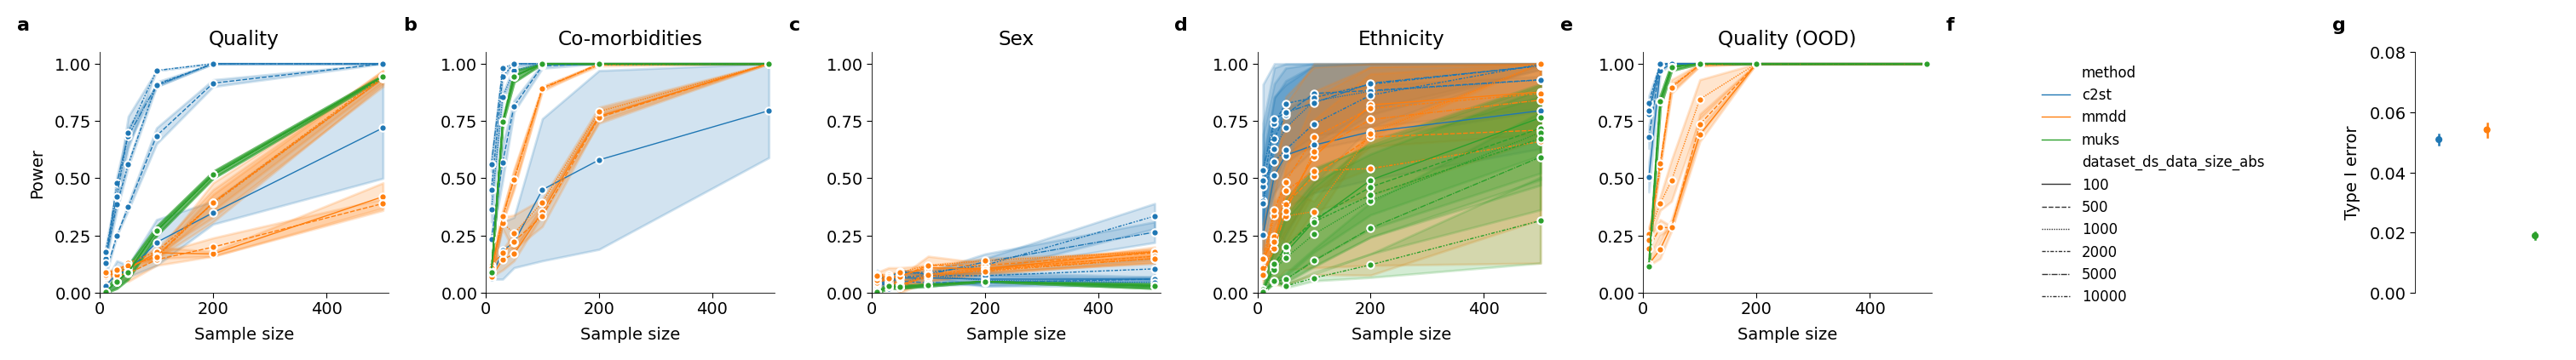

In [13]:

methods = ['c2st', 'mmdd', 'muks']
n_train = [100, 500, 1000, 2000, 5000, 10000]
# n_train = [100, 500, 1000, 2000]

with plt.style.context("../utils/plot_style.txt"):

    num_plots = 7
    fig, ax = plt.subplots(1,num_plots, figsize=(15,2), 
                           gridspec_kw={'width_ratios': [2, 2, 2, 2, 2, 2, 1]},
                        layout="constrained",
                        )



    idx=0
    sns.lineplot(data=quality, x='sample_size', y='power', 
                 hue='method', hue_order=methods,
                 style='dataset_ds_data_size_abs', style_order=n_train,
                 ax=ax[idx], marker='.')
    ax[idx].set_title("Quality")
    
    style_powerplot(ax[idx])

    handles, labels = ax[idx].get_legend_handles_labels()
    # ax[idx].legend(handles=handles, labels=labels, loc='lower right')
    # ax[idx].get_legend().get_frame().set_linewidth(0.0)
    ax[idx].get_legend().remove()


    idx=1
    sns.lineplot(data=comorbids, x='sample_size', y='power', 
                 hue='method', hue_order=methods,
                 style='dataset_ds_data_size_abs', style_order=n_train,
                ax=ax[idx], marker='.')
    ax[idx].set_title("Co-morbidities")
    
    style_powerplot(ax[idx])


    ax[idx].set_ylabel(None)
    ax[idx].get_legend().remove()

    idx=2
    sns.lineplot(data=sex, x='sample_size', y='power', 
                 hue='method', hue_order=methods,
                 style='dataset_ds_data_size_abs', style_order=n_train,
                ax=ax[idx], marker='.')    
    ax[idx].set_title("Sex")
    
    style_powerplot(ax[idx])

    ax[idx].set_ylabel(None)
    ax[idx].get_legend().remove()

    idx=3
    sns.lineplot(data=ethnicity, x='sample_size', y='power', 
                 hue='method', hue_order=methods,
                 style='dataset_ds_data_size_abs', style_order=n_train,
                ax=ax[idx], marker='.')    
    ax[idx].set_title("Ethnicity")
    
    style_powerplot(ax[idx])

    ax[idx].set_ylabel(None)
    ax[idx].get_legend().remove()

    idx=4
    sns.lineplot(data=quality_OOD, x='sample_size', y='power', 
                 hue='method', hue_order=methods,
                 style='dataset_ds_data_size_abs', style_order=n_train,
                ax=ax[idx], marker='.')    
    ax[idx].set_title("Quality (OOD)")
    
    style_powerplot(ax[idx])

    ax[idx].set_ylabel(None)
    ax[idx].get_legend().remove()

    idx=5
    
    ax[idx].legend(handles, labels, loc='upper left')
    # ax[idx].legend(handles=handles, labels=labels, loc='lower right')
    ax[idx].get_legend().get_frame().set_linewidth(0.0)


    # Hide axes in second subplot (optional)
    ax[idx].axis('off')

    idx=6

    bp = sns.pointplot(data=df, x="method", y="type_1err", join=False,  ax=ax[idx], palette=sns.color_palette())

    bp.set(xticklabels=[])
    bp.set(xlabel=None)

    ax[idx].set_ylim([0, 0.08])
    ax[idx].set_ylabel("Type I error")
    ax[idx].set_yticks(y_tick_type1err, )

    ax[idx].spines['bottom'].set_visible(False)
    ax[idx].set_xticks([])


    add_letters(fig, ax)

    fig.savefig('figs/eyepacs_train_set_limited_x_sample_size.pdf')



# Fig. 2: Results summary (ethnicity separate)

2 rows:
row 1: x - train size - y: power at test size 500
row 2: x - test size - y: power at some train size (indicated in row 1)


- Fig 1: 1. Co-morbidities, 2. sex, 3. quality (subgroup), 4. quality (OOD), 5. type I err 


- Fig 2: Ethnicity: Latin, Caucasian, African, Asian, Indian



In [40]:
# check for quality at dataset_ds_data_size_abs = 1000

df = pd.read_csv('all_results_dh.csv')

# df = df[df['dataset_ds_data_size_abs'] == 1000]
df = df[df['sample_size'] == 500]

df = df[df['path'].str.contains("c2st96") == False]
df = df[df['path'].str.contains("gradual") == False]
df = df[df['path'].str.contains("c2st_arch") == False]

df = df[df['path'].str.contains("/eyepacs_quality/")]

df.shape

# df[df['exp_hash'] == '70fd2858a08dd666b5786ecd1ebf707e']['path'].values

(36, 95)

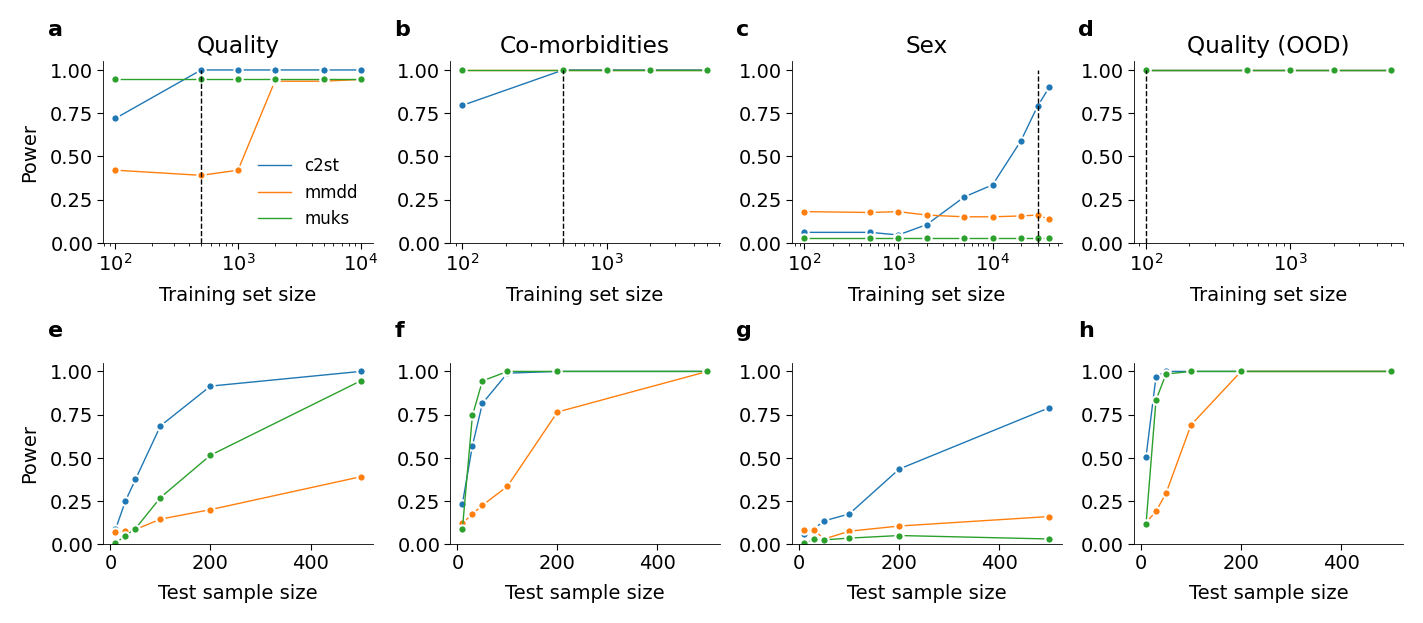

In [48]:

df = pd.read_csv('all_results_dh.csv')

df['n_total'] = df['dataset_ds_data_size_abs'] + df['sample_size']


df = df[df['path'].str.contains("c2st96") == False]
df = df[df['path'].str.contains("gradual") == False]
df = df[df['path'].str.contains("c2st_arch") == False]



quality = df[df['path'].str.contains("/eyepacs_quality/")]
ethnicity = df[df['path'].str.contains("/eyepacs_ethnicity/")]
sex = df[df['path'].str.contains("/eyepacs_sex/")]
comorbids = df[df['path'].str.contains("/eyepacs_comorb/")]
quality_OOD = df[df['path'].str.contains("/eyepacs_quality_OOD/")]


methods = ['c2st', 'mmdd', 'muks']
n_train = [100, 500, 1000, 2000, 5000, 10000]

ssize = 500



with plt.style.context("../utils/plot_style.txt"):

    num_plots = 4
    fig, ax = plt.subplots(2, num_plots, figsize=(7, 3), 
                           gridspec_kw={'width_ratios': [2, 2, 2, 2]},
                        layout="constrained",
                        )


    row = 0

    x_label_top = "Training set size"
    x_label_bottom = "Test sample size"

    idx=0
    sns.lineplot(data=quality[quality['sample_size'] == ssize], x='dataset_ds_data_size_abs', y='power', 
                hue='method', hue_order=methods,
                ci=None,
                # style='sample_size', style_order=sample_sizes,
                ax=ax[row, idx], marker='.')
    ax[row, idx].set_title("Quality")
    
    style_powerplot(ax[row, idx], xlim=None, xlabel=x_label_top)

    handles, labels = ax[row, idx].get_legend_handles_labels()
    ax[row, idx].legend(handles=handles, labels=labels, loc='lower right')
    ax[row, idx].get_legend().get_frame().set_linewidth(0.0)
    # ax[idx].get_legend().remove()
    ax[row, idx].set_xscale('log')


    # single vline with specific ymin and ymax
    
    test_size = 500
    ax[row, idx].vlines(x=test_size, ymin=0, ymax=1, colors='black', ls='--')


    sns.lineplot(data=quality[quality['dataset_ds_data_size_abs'] == test_size], x='sample_size', y='power', 
                hue='method', hue_order=methods,
                ci=None,
                # style='sample_size', style_order=sample_sizes,
                ax=ax[1, idx], marker='.')
    # ax[1, idx].set_title("Quality")
    
    ax[1, idx].get_legend().remove()

    style_powerplot(ax[1, idx], xlim=None, xlabel=x_label_bottom)


    idx=1
    sns.lineplot(data=comorbids[comorbids['sample_size'] == ssize], x='dataset_ds_data_size_abs', y='power', 
                hue='method', hue_order=methods,
                ci=None,
                # style='sample_size', style_order=sample_sizes,
                ax=ax[row, idx], marker='.')
    ax[row, idx].set_title("Co-morbidities")
    
    style_powerplot(ax[row, idx], xlim=None, xlabel=x_label_top)


    ax[row, idx].set_ylabel(None)
    ax[row, idx].get_legend().remove()
    ax[row, idx].set_xscale('log')

    test_size = 500
    ax[row, idx].vlines(x=test_size, ymin=0, ymax=1, colors='black', ls='--')


    sns.lineplot(data=comorbids[comorbids['dataset_ds_data_size_abs'] == test_size], x='sample_size', y='power', 
                hue='method', hue_order=methods,
                ci=None,
                ax=ax[1, idx], marker='.')
    # ax[1, idx].set_title("Quality")
    
    ax[1, idx].get_legend().remove()

    style_powerplot(ax[1, idx], xlim=None, xlabel=x_label_bottom)
    ax[1, idx].set_ylabel(None)
    ax[row, idx].set_xscale('log')

    idx=2
    sns.lineplot(data=sex[sex['sample_size'] == ssize], x='dataset_ds_data_size_abs', y='power', 
                hue='method', hue_order=methods,
                ci=None,
                ax=ax[row, idx], marker='.')    
    ax[row, idx].set_title("Sex")
    
    style_powerplot(ax[row, idx], xlim=None, xlabel=x_label_top)

    ax[row, idx].set_ylabel(None)
    ax[row, idx].get_legend().remove()
    ax[row, idx].set_xscale('log')

    test_size = 30000
    ax[row, idx].vlines(x=test_size, ymin=0, ymax=1, colors='black', ls='--')


    sns.lineplot(data=sex[sex['dataset_ds_data_size_abs'] == test_size], x='sample_size', y='power', 
                hue='method', hue_order=methods,
                ci=None,
                ax=ax[1, idx], marker='.')
    # ax[1, idx].set_title("Quality")
    
    style_powerplot(ax[1, idx], xlim=None, xlabel=x_label_bottom)
    ax[1, idx].set_ylabel(None)
    ax[1, idx].get_legend().remove()


    idx=3
    sns.lineplot(data=quality_OOD[quality_OOD['sample_size'] == ssize], x='dataset_ds_data_size_abs', y='power', 
                hue='method', hue_order=methods,
                ci=None,
                ax=ax[row, idx], marker='.')    
    ax[row, idx].set_title("Quality (OOD)")
    
    style_powerplot(ax[row, idx], xlim=None, xlabel=x_label_top)

    ax[row, idx].set_ylabel(None)
    ax[row, idx].get_legend().remove()
    ax[row, idx].set_xscale('log')

    test_size = 100
    ax[row, idx].vlines(x=test_size, ymin=0, ymax=1, colors='black', ls='--')

    sns.lineplot(data=quality_OOD[quality_OOD['dataset_ds_data_size_abs'] == 100], x='sample_size', y='power', 
                hue='method', hue_order=methods,
                ci=None,
                ax=ax[1, idx], marker='.')
    # ax[1, idx].set_title("Quality")
    
    style_powerplot(ax[1, idx], xlim=None, xlabel=x_label_bottom)
    ax[1, idx].set_ylabel(None)
    ax[1, idx].get_legend().remove()


    # idx=4

    # bp = sns.pointplot(data=df, x="method", y="type_1err", join=False,  ax=ax[row, idx], palette=sns.color_palette())

    # bp.set(xticklabels=[])
    # bp.set(xlabel=None)

    # ax[row, idx].set_ylim([0, 0.08])
    # ax[row, idx].set_ylabel("Type I error")
    # ax[row, idx].set_yticks(y_tick_type1err, )

    # ax[row, idx].spines['bottom'].set_visible(False)
    # ax[row, idx].set_xticks([])



    # ax[1, idx].remove()


    add_letters(fig, ax, dx=-20/72.)

    fig.savefig('figs/eyepacs_qual_comorbid_sex_ood.pdf')

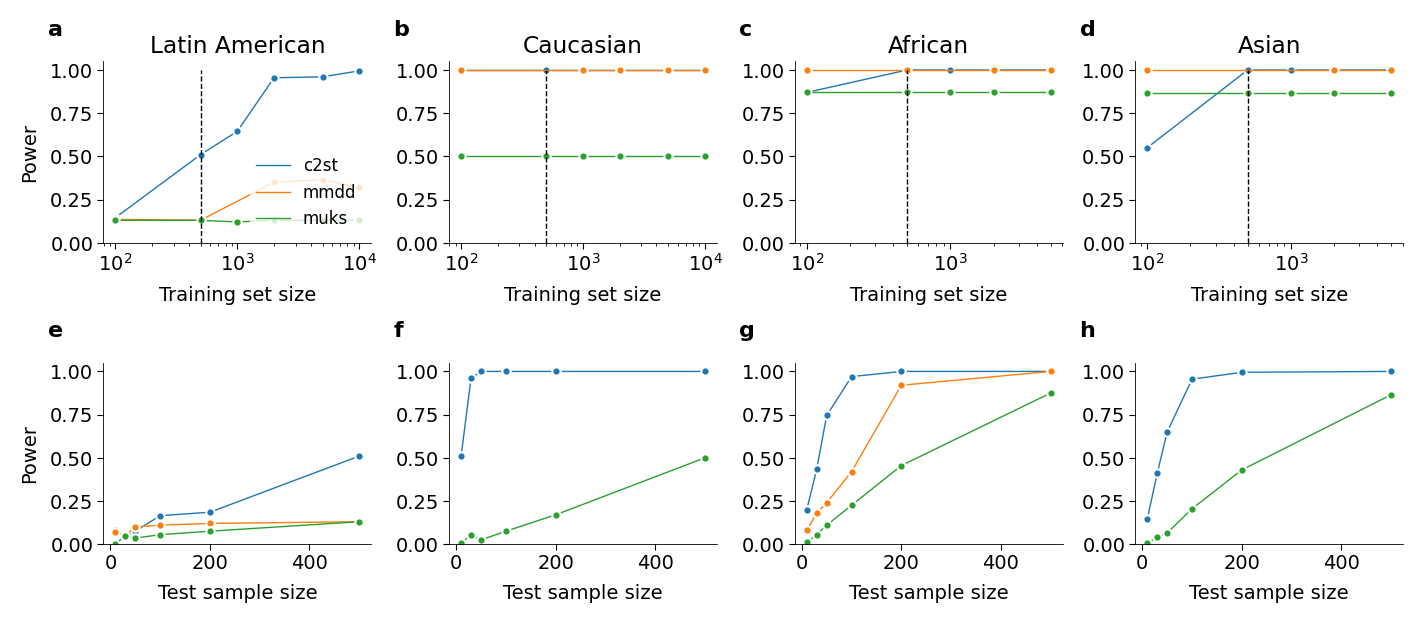

In [46]:
methods = ['c2st', 'mmdd', 'muks']
n_train = [100, 500, 1000, 2000, 5000, 10000]
# n_train = [100, 500, 1000, 2000]

ssize = 500

ethnicity = df[df['path'].str.contains("/eyepacs_ethnicity/")]

# keep Latin American and Caucasian only

ethnicity = ethnicity.dropna(subset=["dataset_ds_q_subset_params_patient_ethnicity"])

# function that checks whether the integer 1 is in the list
def contains_main_groups(lst, group="African Descent"):
    return group in lst


latin_american = ethnicity[ethnicity['dataset_ds_q_subset_params_patient_ethnicity'].apply(contains_main_groups, args=("Latin American",))]
caucasian = ethnicity[ethnicity['dataset_ds_q_subset_params_patient_ethnicity'].apply(contains_main_groups, args=("Caucasian",))]
african = ethnicity[ethnicity['dataset_ds_q_subset_params_patient_ethnicity'].apply(contains_main_groups, args=("African Descent",))]
asian = ethnicity[ethnicity['dataset_ds_q_subset_params_patient_ethnicity'].apply(contains_main_groups, args=("Asian",))]
indian = ethnicity[ethnicity['dataset_ds_q_subset_params_patient_ethnicity'].apply(contains_main_groups, args=("Indian subcontinent origin",))]
multiracial = ethnicity[ethnicity['dataset_ds_q_subset_params_patient_ethnicity'].apply(contains_main_groups, args=("Multi-racial",))]
native = ethnicity[ethnicity['dataset_ds_q_subset_params_patient_ethnicity'].apply(contains_main_groups, args=("Native American",))]



with plt.style.context("../utils/plot_style.txt"):

    num_plots = 4
    fig, ax = plt.subplots(2, num_plots, figsize=(7, 3), 
                           gridspec_kw={'width_ratios': [2, 2, 2, 2]},
                        layout="constrained",
                        )


    row = 0

    x_label_top = "Training set size"
    x_label_bottom = "Test sample size"

    idx=0
    sns.lineplot(data=latin_american[latin_american['sample_size'] == ssize], x='dataset_ds_data_size_abs', y='power', 
                hue='method', hue_order=methods,
                ci=None,
                # style='sample_size', style_order=sample_sizes,
                ax=ax[row, idx], marker='.')
    ax[row, idx].set_title("Latin American")
    
    style_powerplot(ax[row, idx], xlim=None, xlabel=x_label_top)

    handles, labels = ax[row, idx].get_legend_handles_labels()
    ax[row, idx].legend(handles=handles, labels=labels, loc='lower right')
    ax[row, idx].get_legend().get_frame().set_linewidth(0.0)
    # ax[idx].get_legend().remove()
    ax[row, idx].set_xscale('log')


    # single vline with specific ymin and ymax
    
    test_size = 500
    ax[row, idx].vlines(x=test_size, ymin=0, ymax=1, colors='black', ls='--')


    sns.lineplot(data=latin_american[latin_american['dataset_ds_data_size_abs'] == test_size], x='sample_size', y='power', 
                hue='method', hue_order=methods,
                ci=None,
                # style='sample_size', style_order=sample_sizes,
                ax=ax[1, idx], marker='.')
    
    ax[1, idx].get_legend().remove()

    style_powerplot(ax[1, idx], xlim=None, xlabel=x_label_bottom)


    idx=1
    sns.lineplot(data=caucasian[caucasian['sample_size'] == ssize], x='dataset_ds_data_size_abs', y='power', 
                hue='method', hue_order=methods,
                ci=None,
                # style='sample_size', style_order=sample_sizes,
                ax=ax[row, idx], marker='.')
    ax[row, idx].set_title("Caucasian")
    
    style_powerplot(ax[row, idx], xlim=None, xlabel=x_label_top)


    ax[row, idx].set_ylabel(None)
    ax[row, idx].get_legend().remove()

    test_size = 500
    ax[row, idx].vlines(x=test_size, ymin=0, ymax=1, colors='black', ls='--')
    ax[row, idx].set_xscale('log')


    sns.lineplot(data=caucasian[caucasian['dataset_ds_data_size_abs'] == test_size], x='sample_size', y='power', 
                hue='method', hue_order=methods,
                ci=None,
                ax=ax[1, idx], marker='.')
    # ax[1, idx].set_title("Quality")
    
    ax[1, idx].get_legend().remove()

    style_powerplot(ax[1, idx], xlim=None, xlabel=x_label_bottom)
    ax[1, idx].set_ylabel(None)

    idx=2
    sns.lineplot(data=african[african['sample_size'] == ssize], x='dataset_ds_data_size_abs', y='power', 
                ci=None,
                hue='method', hue_order=methods,
                ax=ax[row, idx], marker='.')    
    ax[row, idx].set_title("African")
    
    style_powerplot(ax[row, idx], xlim=None, xlabel=x_label_top)

    ax[row, idx].set_ylabel(None)
    ax[row, idx].get_legend().remove()

    test_size = 500
    ax[row, idx].vlines(x=test_size, ymin=0, ymax=1, colors='black', ls='--')
    ax[row, idx].set_xscale('log')


    sns.lineplot(data=african[african['dataset_ds_data_size_abs'] == test_size], x='sample_size', y='power', 
                ci=None,
                hue='method', hue_order=methods,
                ax=ax[1, idx], marker='.')
    # ax[1, idx].set_title("Quality")
    
    style_powerplot(ax[1, idx], xlim=None, xlabel=x_label_bottom)
    ax[1, idx].set_ylabel(None)
    ax[1, idx].get_legend().remove()


    idx=3
    sns.lineplot(data=asian[asian['sample_size'] == ssize], x='dataset_ds_data_size_abs', y='power', 
                ci=None,
                hue='method', hue_order=methods,
                ax=ax[row, idx], marker='.')    
    ax[row, idx].set_title("Asian")
    
    style_powerplot(ax[row, idx], xlim=None, xlabel=x_label_top)

    ax[row, idx].set_ylabel(None)
    ax[row, idx].get_legend().remove()

    test_size = 500
    ax[row, idx].vlines(x=test_size, ymin=0, ymax=1, colors='black', ls='--')
    ax[row, idx].set_xscale('log')

    sns.lineplot(data=asian[asian['dataset_ds_data_size_abs'] == test_size], x='sample_size', y='power', 
                ci=None,
                hue='method', hue_order=methods,
                ax=ax[1, idx], marker='.')
    # ax[1, idx].set_title("Quality")
    
    style_powerplot(ax[1, idx], xlim=None, xlabel=x_label_bottom)
    ax[1, idx].set_ylabel(None)
    ax[1, idx].get_legend().remove()

    # add_letters(fig, ax)

    # idx=4

    # bp = sns.pointplot(data=ethnicity, x="method", y="type_1err", join=False,  ax=ax[row, idx], palette=sns.color_palette())

    # bp.set(xticklabels=[])
    # bp.set(xlabel=None)

    # ax[row, idx].set_ylim([0, 0.08])
    # ax[row, idx].set_ylabel("Type I error")
    # ax[row, idx].set_yticks(y_tick_type1err, )

    # ax[row, idx].spines['bottom'].set_visible(False)
    # ax[row, idx].set_xticks([])



    # ax[1, idx].remove()

    add_letters(fig, ax, dx=-20/72.)

    fig.savefig('figs/eyepacs_ethnicity.pdf')

# Ablations

- img resolution at n_train = 1000

C2ST-512, C2ST-96, MMDD-96



In [33]:
df = pd.read_csv('all_results_dh.csv')

df['n_total'] = df['dataset_ds_data_size_abs'] + df['sample_size']


# df = df[df['path'].str.contains("c2st96") == False]
df = df[df['path'].str.contains("gradual") == False]
df = df[df['path'].str.contains("c2st_arch") == False]


df = df[df['dataset_ds_data_size_abs'] == 1000]


quality = df[df['path'].str.contains("/eyepacs_quality/")]
ethnicity = df[df['path'].str.contains("/eyepacs_ethnicity/")]
sex = df[df['path'].str.contains("/eyepacs_sex/")]
comorbids = df[df['path'].str.contains("/eyepacs_comorb/")]
quality_OOD = df[df['path'].str.contains("/eyepacs_quality_OOD/")]

quality['attribute'] = "Quality"
quality_OOD['attribute'] = "Quality (OOD)"
comorbids['attribute'] = "Co-morbidities"
ethnicity['attribute'] = "Ethnicity"
sex['attribute'] = "Sex"

# TODO: include c2st96, evaluate at n_train = 1000



table_results = pd.concat([quality, comorbids, ethnicity, sex, quality_OOD])
# table_results = table_results[['method', 'attribute', 'sample_size', 'power', 'dataset_ds_basic_preproc_img_size']]

table_results
table_results = table_results.groupby(["sample_size", "method", "dataset_ds_basic_preproc_img_size", "attribute"])['power'].mean().reset_index()


table_rows = []

title_row_1 = "Shift & Test & 10 & 30 & 50 & 100 & 200 & 500 \n"
table_rows.append(title_row_1)

table_rows.append("\hline \n")

for shift_type in table_results['attribute'].unique():
    print(shift_type)

    c2st512 = table_results[(table_results['attribute'] == shift_type) & (table_results['dataset_ds_basic_preproc_img_size'] == 512)  & (table_results['method'] == "c2st")]
    c2st96 = table_results[(table_results['attribute'] == shift_type) & (table_results['dataset_ds_basic_preproc_img_size'] == 96)  & (table_results['method'] == "c2st")]
    mmdd = table_results[(table_results['attribute'] == shift_type) & (table_results['method'] == "mmdd")]

    row = f"{shift_type} & C2ST-512 & " + ' & '.join([f"{ele:.02f}" for ele in list(c2st512['power'])]) + "\\\\  \n"
    table_rows.append(row)

    row = f"{shift_type} & C2ST-96 & " + ' & '.join([f"{ele:.02f}" for ele in list(c2st96['power'])]) + "\\\\  \n"
    table_rows.append(row)

    row = f"{shift_type} & MMDD-96 & " + ' & '.join([f"{ele:.02f}" for ele in list(mmdd['power'])]) + "\\\\  \n"
    table_rows.append(row)

    table_rows.append("\hline \n")


table_file = "size_ablation_table.txt"
with open(table_file, "w") as f:
    f.writelines(table_rows)


Co-morbidities
Ethnicity
Quality
Sex
Quality (OOD)


/tmp/ipykernel_18355/1488247236.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  quality['attribute'] = "Quality"
/tmp/ipykernel_18355/1488247236.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  quality_OOD['attribute'] = "Quality (OOD)"
/tmp/ipykernel_18355/1488247236.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/st

In [88]:
df = pd.read_csv('all_results_dh.csv')

df['n_total'] = df['dataset_ds_data_size_abs'] + df['sample_size']


df = df[df['path'].str.contains("c2st96") == False]
df = df[df['path'].str.contains("gradual") == False]
# df = df[df['path'].str.contains("c2st_arch") == False]


df = df[df['dataset_ds_data_size_abs'] == 1000]
df = df[df['method'] == 'c2st']


df = df[df['path'].str.contains("/eyepacs_quality/")]

# quality['attribute'] = "Quality"


df['attribute'] = df['domain_classifier_model_arch']

# df = df.dropna(subset=["dataset_ds_q_subset_params_session_image_quality"])


df['attribute']
df.shape

# TODO where are the shallows?

table_results = df
# table_results = table_results[['method', 'attribute', 'sample_size', 'power', 'dataset_ds_basic_preproc_img_size']]

table_results
table_results = table_results.groupby(["sample_size", "method", "attribute"])['power'].mean().reset_index()

table_results

sample_size method attribute  power
0            10   c2st  resnet18  0.085
1            10   c2st  resnet50  0.135
2            10   c2st   shallow  0.035
3            30   c2st  resnet18  0.200
4            30   c2st  resnet50  0.290
5            30   c2st   shallow  0.075
6            50   c2st  resnet18  0.405
7            50   c2st  resnet50  0.465
8            50   c2st   shallow  0.080
9           100   c2st  resnet18  0.745
10          100   c2st  resnet50  0.810
11          100   c2st   shallow  0.055
12          200   c2st  resnet18  0.965
13          200   c2st  resnet50  0.955
14          200   c2st   shallow  0.130
15          500   c2st  resnet18  0.995
16          500   c2st  resnet50  1.000
17          500   c2st   shallow  0.180

In [89]:


table_rows = []

title_row_1 = "Architecture & 10 & 30 & 50 & 100 & 200 & 500 \n"
table_rows.append(title_row_1)

table_rows.append("\hline \n")

for shift_type in table_results['attribute'].unique():
    print(shift_type)

    row_vals = table_results[table_results['attribute'] == shift_type]

    row = f"{shift_type}  & " + ' & '.join([f"{ele:.02f}" for ele in list(row_vals['power'])]) + "\\\\  \n"
    table_rows.append(row)

    table_rows.append("\hline \n")


table_file = "arch_ablation_table.txt"
with open(table_file, "w") as f:
    f.writelines(table_rows)


resnet18
resnet50
shallow


- Architecture for C2ST

## Total sample size on x-axis (not test sample size)

# Example images: MNIST

Dataset MNIST
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               RandomErasing(p=0.5, scale=(0.2, 0.2), ratio=(1, 1), value=0, inplace=False)
               ToPILImage()
               Compose(
               Resize(size=32, interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
               CenterCrop(size=(32, 32))
               Normalize(mean=[0.1307], std=[0.3081])
           )
           )
Dataset MNIST
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               RandomErasing(p=1, scale=(0.2, 0.2), ratio=(1, 1), value=0, inplace=False)
               ToPILImage()
               Compose(
               Resize(size=32, interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
               CenterCrop(size=(32, 32))
               N

/home/lkoch/miniconda3/envs/rebuttal/lib/python3.9/site-packages/torchvision/transforms/transforms.py:1375: UserWarning: Argument fillcolor is deprecated and will be removed since v0.10.0. Please, use fill instead
  warnings.warn(
/home/lkoch/miniconda3/envs/rebuttal/lib/python3.9/site-packages/torchvision/transforms/transforms.py:1375: UserWarning: Argument fillcolor is deprecated and will be removed since v0.10.0. Please, use fill instead
  warnings.warn(


Dataset MNIST
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               RandomErasing(p=0, scale=(0.2, 0.2), ratio=(1, 1), value=0, inplace=False)
               ToPILImage()
               Compose(
               Resize(size=32, interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
               CenterCrop(size=(32, 32))
               Normalize(mean=[0.1307], std=[0.3081])
           )
           )
Dataset MNIST
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               RandomErasing(p=1, scale=(0.2, 0.2), ratio=(1, 1), value=0, inplace=False)
               ToPILImage()
               Compose(
               Resize(size=32, interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
               CenterCrop(size=(32, 32))
               Nor

/home/lkoch/miniconda3/envs/rebuttal/lib/python3.9/site-packages/torchvision/transforms/transforms.py:1375: UserWarning: Argument fillcolor is deprecated and will be removed since v0.10.0. Please, use fill instead
  warnings.warn(
/home/lkoch/miniconda3/envs/rebuttal/lib/python3.9/site-packages/torchvision/transforms/transforms.py:1375: UserWarning: Argument fillcolor is deprecated and will be removed since v0.10.0. Please, use fill instead
  warnings.warn(


Dataset MNIST
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               RandomErasing(p=1, scale=(0.2, 0.2), ratio=(1, 1), value=0, inplace=False)
               ToPILImage()
               Compose(
               Resize(size=32, interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
               CenterCrop(size=(32, 32))
               Normalize(mean=[0.1307], std=[0.3081])
           )
           )
Dataset MNIST
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               RandomErasing(p=1, scale=(0.2, 0.2), ratio=(1, 1), value=0, inplace=False)
               ToPILImage()
               Compose(
               Resize(size=32, interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
               CenterCrop(size=(32, 32))
               Nor

/home/lkoch/miniconda3/envs/rebuttal/lib/python3.9/site-packages/torchvision/transforms/transforms.py:1375: UserWarning: Argument fillcolor is deprecated and will be removed since v0.10.0. Please, use fill instead
  warnings.warn(
/home/lkoch/miniconda3/envs/rebuttal/lib/python3.9/site-packages/torchvision/transforms/transforms.py:1375: UserWarning: Argument fillcolor is deprecated and will be removed since v0.10.0. Please, use fill instead
  warnings.warn(


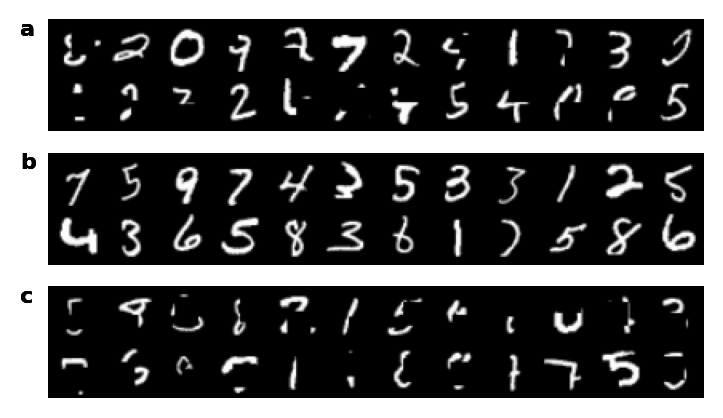

In [33]:
import os

import matplotlib.pyplot as plt
import numpy as np
import torchvision
from core.dataset import dataset_fn
from utils.config import load_config

# MNIST

config_file = "../config/lightning/mnist.yaml"
params = load_config(config_file)

out_dir = "/home/lkoch/Dropbox/BerensLab/Papers/2022_tmi_subgroups/figures"
out_dir = "."


with plt.style.context("../utils/plot_style.txt"):

    fig, ax = plt.subplots(3, 1, figsize=(3.5, 2), layout="constrained")

    for idx, p in enumerate([0.5, 0, 1]):

        params["dataset"]["ds"]["p"]["subset_params"]["p_erase"] = p
        dataloader = dataset_fn(params_dict=params["dataset"])

        _, (x, *_) = next(enumerate(dataloader["train"]["p"]))

        img_grid = torchvision.utils.make_grid(x[:24], nrow=12, normalize=True)
        img_grid = np.transpose(img_grid, (1, 2, 0)).numpy()

        
        ax[idx].imshow(img_grid)
        ax[idx].axis("off")
        add_letters(fig, ax, dx=-10/72., dy=0)
    
    out_fig = os.path.join(out_dir, f"mnist_examples.pdf")
    fig.savefig(out_fig)


# Example images: Camelyon

/home/lkoch/miniconda3/envs/rebuttal/lib/python3.9/site-packages/torchvision/transforms/transforms.py:1375: UserWarning: Argument fillcolor is deprecated and will be removed since v0.10.0. Please, use fill instead
  warnings.warn(


center [0, 1, 2, 3, 4]
center [0, 1, 2, 3, 4]
center [0, 1, 2, 3, 4]
center [0, 1, 2, 3, 4]
center [0, 1, 2, 3, 4]
center [0, 1, 2, 3, 4]
center [0, 1, 2, 3, 4]
center [0, 1, 2, 3, 4]
center [0, 1, 2, 3, 4]
center [0]
center [0]
center [0]
center [0, 1, 2, 3, 4]
center [0, 1, 2, 3, 4]
center [0, 1, 2, 3, 4]
center [1]
center [1]
center [1]
center [0, 1, 2, 3, 4]
center [0, 1, 2, 3, 4]
center [0, 1, 2, 3, 4]
center [2]
center [2]
center [2]
center [0, 1, 2, 3, 4]
center [0, 1, 2, 3, 4]
center [0, 1, 2, 3, 4]
center [3]
center [3]
center [3]
center [0, 1, 2, 3, 4]
center [0, 1, 2, 3, 4]
center [0, 1, 2, 3, 4]
center [4]
center [4]
center [4]


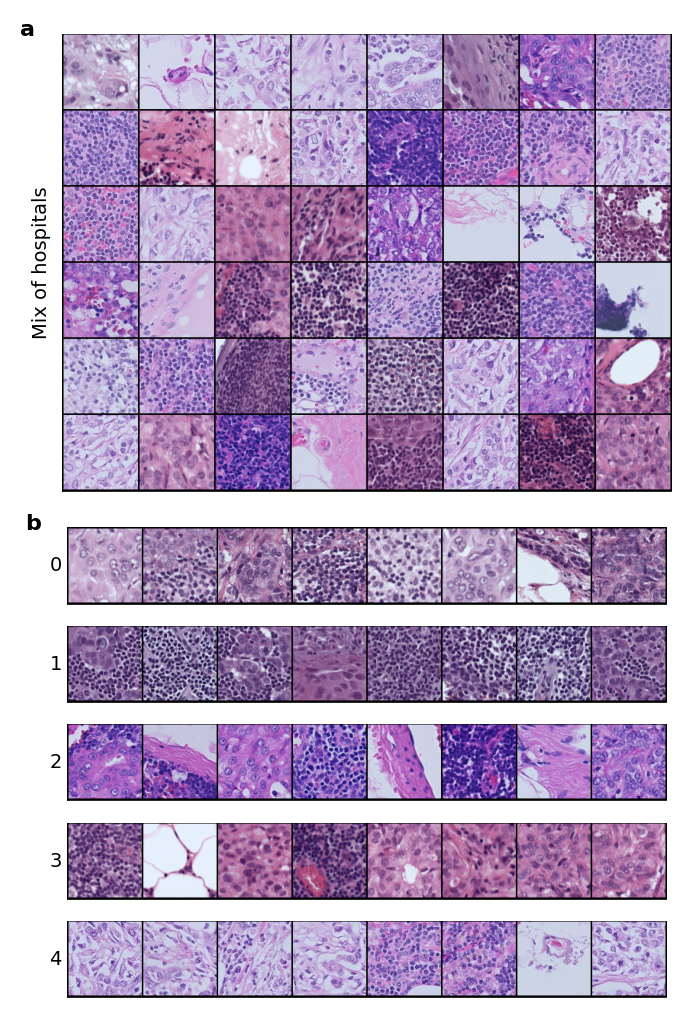

In [35]:

import torch
# Camelyon

config_file = "../config/lightning/camelyon_example_images.yaml"
params = load_config(config_file)

# out_dir = "/home/lkoch/Dropbox/BerensLab/Papers/2022_tmi_subgroups/figures"
out_dir = "."


with plt.style.context("../utils/plot_style.txt"):

    fig, ax = plt.subplots(6, 1, figsize=(3.5, 5),
                           gridspec_kw={'height_ratios': [6, 1, 1, 1, 1, 1]},
                           layout="constrained"
                )
    
    dataloader = dataset_fn(params_dict=params["dataset"])
    _, (x1, *_) = next(enumerate(dataloader["train"]["p"]))
    _, (x2, *_) = next(enumerate(dataloader["train"]["p"]))
    _, (x3, *_) = next(enumerate(dataloader["train"]["p"]))
    
    x = torch.cat((x1, x2, x3))

    img_grid = torchvision.utils.make_grid(x, normalize=True)
    img_grid = np.transpose(img_grid, (1, 2, 0)).numpy()
    
    ax[0].imshow(img_grid)
    # ax[0].axis("off")
    # ax[0].set_xlabel("All hospitals")
    ax[0].set_xticks([])
    ax[0].set_yticks([])
    ax[0].set_ylabel("Mix of hospitals")
        
    # # plt.rcParams["figure.autolayout"] = True
    # # im = plt.imread('bird.jpg') # insert local path of the image.
    # fig, ax = plt.subplots()
    # # ax.set_xlim()
    # newax = fig.add_axes([0, 0, 0, 0], anchor='NW', zorder=1)
    # newax.imshow(img_grid)
    # newax.axis('off')
    # plt.show()
    
    # y_images = []
    for idx in range(5):

        params["dataset"]["ds"]["q"]["subset_params"]["center"] = [idx]
        dataloader = dataset_fn(params_dict=params["dataset"])

        _, (y, *_) = next(enumerate(dataloader["train"]["q"]))

        img_grid = torchvision.utils.make_grid(y[:8], normalize=True)
        img_grid = np.transpose(img_grid, (1, 2, 0)).numpy()
        
        # y_images.append(img_grid)
        
        ax[idx+1].imshow(img_grid)
        # ax[idx+1].axis("off")

        ax[idx+1].set_xticks([])
        ax[idx+1].set_yticks([])
        ax[idx+1].set_ylabel(f"{idx}", rotation=0, ha='center', va='center',)

    add_letters(fig, ax[:2], dx=-15/72., dy=5/72.)

    out_fig = os.path.join(out_dir, f"camelyon_examples.pdf")
    fig.savefig(out_fig)

